# Customer Churn Prediction

**Objective:** Predict which customers are likely to churn using machine learning and provide actionable business insights.

In [1]:
import pandas as pd

# Load CSV
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

# Quick look at first rows
df.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


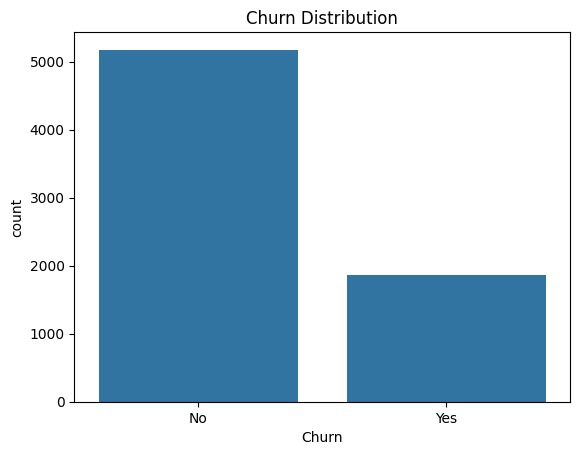

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

# Check missing values
print(df.isnull().sum())

# Distribution of target variable
sns.countplot(x='Churn', data=df)
plt.title("Churn Distribution")
plt.show()


In [3]:
from sklearn.preprocessing import LabelEncoder

# Convert categorical columns to numbers
le = LabelEncoder()
for col in df.select_dtypes(include='object').columns:
    if col != 'customerID':  # drop or ignore ID
        df[col] = le.fit_transform(df[col])

# Split features and target
X = df.drop(['customerID','Churn'], axis=1)
y = df['Churn']

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [4]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    class_weight='balanced',
    random_state=42
)

rf_model.fit(X_train, y_train)

# Predict
y_pred = rf_model.predict(X_test)
y_proba = rf_model.predict_proba(X_test)[:,1]

from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[824 212]
 [ 89 284]]
              precision    recall  f1-score   support

           0       0.90      0.80      0.85      1036
           1       0.57      0.76      0.65       373

    accuracy                           0.79      1409
   macro avg       0.74      0.78      0.75      1409
weighted avg       0.82      0.79      0.79      1409



In [5]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# Predicted probabilities
y_proba = rf_model.predict_proba(X_test)[:,1]
y_pred = rf_model.predict(X_test)

# Confusion matrix & classification report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[824 212]
 [ 89 284]]
              precision    recall  f1-score   support

           0       0.90      0.80      0.85      1036
           1       0.57      0.76      0.65       373

    accuracy                           0.79      1409
   macro avg       0.74      0.78      0.75      1409
weighted avg       0.82      0.79      0.79      1409



In [6]:
import os
os.makedirs("images", exist_ok=True)

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Random Forest ROC Curve")
plt.legend()
plt.savefig("images/rf_roc.png", bbox_inches='tight')
plt.close()

# Feature Importance (top 10)
import numpy as np
feat_importances = rf_model.feature_importances_
top_n = 10
indices = np.argsort(feat_importances)[-top_n:]
top_features = X_train.columns[indices]
top_importances = feat_importances[indices]

plt.figure(figsize=(6,4), dpi=80)
plt.barh(top_features, top_importances)
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Top 10 Random Forest Feature Importance")
plt.tight_layout()
plt.savefig("images/rf_feature_importance.png")
plt.close()

print("✅ ROC and feature importance images saved in 'images/' folder")


✅ ROC and feature importance images saved in 'images/' folder


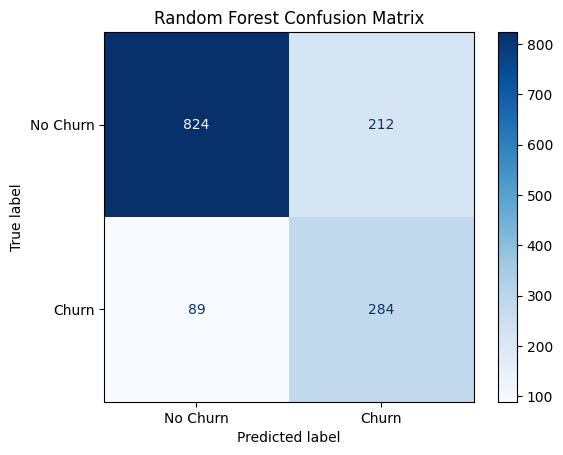

In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Make predictions
y_pred = rf_model.predict(X_test)

# Plot confusion matrix
disp = ConfusionMatrixDisplay.from_estimator(
    rf_model,
    X_test,
    y_test,
    display_labels=["No Churn", "Churn"],
    cmap=plt.cm.Blues,
    normalize=None  # Use 'true' if you want percentages
)

plt.title("Random Forest Confusion Matrix")
plt.savefig("images/rf_confusion_matrix.png", bbox_inches='tight')
plt.show()


In [9]:
import joblib

# Save the trained Random Forest model directly
joblib.dump(rf_model, "churn_model.pkl")

print("Random Forest model saved as churn_model.pkl")


Random Forest model saved as churn_model.pkl


## Business Insights

- Customers with **higher tenure** are less likely to churn.
- Certain services/features have a higher impact on churn — see feature importance plot.
- The model recall shows we can identify most churners for retention campaigns.

## Conclusion

- Random Forest with class_weight='balanced' gave a good balance between accuracy and recall.
- ROC curve shows strong predictive power.
- This project demonstrates data-driven churn prediction and actionable insights.
